In [40]:
import torch

DEVICE = torch.device( 'cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = 'vit_h'

In [72]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /Users/anshmadan/Coding/IML Final Project


In [73]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/Users/anshmadan/Coding/IML Final Project/weights/sam_vit_h_4b8939.pth ; exist: True


In [74]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

In [77]:
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.85,  # Slightly lower to get more masks
    stability_score_thresh=0.90,  # Slightly lower to allow more masks
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100
)

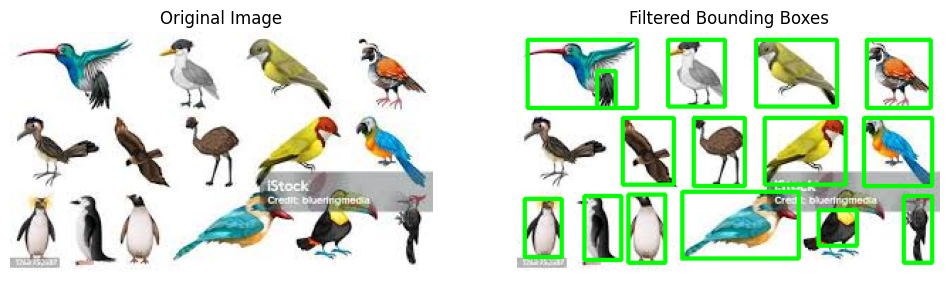

In [76]:
import numpy as np
import cv2

# Define multiple color ranges for different bird colors
bird_color_ranges = [
    # Dark birds (gray/black)
    (np.array([0, 0, 0]), np.array([180, 50, 180])),
    # Brown/red birds
    (np.array([0, 30, 30]), np.array([25, 255, 255])),
    # Yellow/bright birds
    (np.array([15, 50, 50]), np.array([40, 255, 255])),
    # White birds
    (np.array([0, 0, 180]), np.array([180, 50, 255])),
    # Blue birds
    (np.array([90, 50, 50]), np.array([130, 255, 255]))
]

def create_color_mask(image_hsv, ranges):
    final_mask = np.zeros(image_hsv.shape[:2], dtype=np.uint8)
    for lower, upper in ranges:
        mask = cv2.inRange(image_hsv, lower, upper)
        final_mask = cv2.bitwise_or(final_mask, mask)
    return final_mask

# Convert image to HSV
image_hsv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)

# Create combined color mask for birds
color_mask = create_color_mask(image_hsv, bird_color_ranges)

# Apply morphological operations to clean up the mask
kernel = np.ones((3,3), np.uint8)
color_mask = cv2.morphologyEx(color_mask, cv2.MORPH_OPEN, kernel)
color_mask = cv2.morphologyEx(color_mask, cv2.MORPH_CLOSE, kernel)

# Filter masks based on color and shape characteristics
filtered_masks = []
for mask in sam_result:
    segmentation = mask['segmentation'].astype(np.uint8)
    
    # Calculate overlap with color mask
    overlap = cv2.bitwise_and(segmentation, color_mask)
    overlap_ratio = np.sum(overlap) / np.sum(segmentation)
    
    # Calculate contour properties
    contours, _ = cv2.findContours(segmentation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
        contour = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        
        # Calculate shape features
        circularity = 4 * np.pi * area / (perimeter * perimeter) if perimeter > 0 else 0
        
        # Bird-specific filtering criteria
        if (overlap_ratio > 0.2 and  # More lenient color match
            200 < area < 25000 and   # Wider size range
            0.1 < circularity < 0.9): # More lenient shape criteria
            filtered_masks.append(segmentation)

# Generate bounding boxes with improved filtering
bounding_boxes = []
for mask in filtered_masks:
    binary_mask = (mask > 0).astype(np.uint8)
    coords = np.where(binary_mask == 1)
    if len(coords[0]) > 0 and len(coords[1]) > 0:
        y_coords, x_coords = coords
        x_min, x_max = x_coords.min(), x_coords.max()
        y_min, y_max = y_coords.min(), y_coords.max()
        
        # Calculate aspect ratio and density
        width = x_max - x_min + 1
        height = y_max - y_min + 1
        aspect_ratio = height / width
        area = width * height
        density = np.sum(binary_mask[y_min:y_max+1, x_min:x_max+1]) / area
        
        # More precise bird-specific filtering
        if (0.3 < aspect_ratio < 3.0 and    # More flexible aspect ratios
            density > 0.15 and              # More lenient density threshold
            200 < area < 25000):            # Wider size range for birds
            bounding_boxes.append((x_min, y_min, x_max, y_max))

# Apply Non-Maximum Suppression with adjusted overlap threshold
def non_max_suppression(boxes, overlap_thresh=0.2):  # Lower threshold for better separation
    if len(boxes) == 0:
        return []
    boxes = np.array(boxes)
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    indices = np.argsort(y2)
    picked = []
    
    while len(indices) > 0:
        last = len(indices) - 1
        i = indices[last]
        picked.append(i)
        
        xx1 = np.maximum(x1[i], x1[indices[:last]])
        yy1 = np.maximum(y1[i], y1[indices[:last]])
        xx2 = np.minimum(x2[i], x2[indices[:last]])
        yy2 = np.minimum(y2[i], y2[indices[:last]])
        
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        overlap = (w * h) / areas[indices[:last]]
        
        indices = np.delete(indices, np.concatenate(([last], np.where(overlap > overlap_thresh)[0])))
    
    return boxes[picked].tolist()

# Filter bounding boxes using NMS
final_boxes = non_max_suppression(bounding_boxes)

# Draw bounding boxes on the original image
output_image = image_bgr.copy()
for (x_min, y_min, x_max, y_max) in final_boxes:
    cv2.rectangle(output_image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

# Visualize the results
images = [image_bgr, output_image]
titles = ["Original Image", "Filtered Bounding Boxes"]
sv.plot_images_grid(
    images=images,
    grid_size=(1, 2),
    titles=titles
)

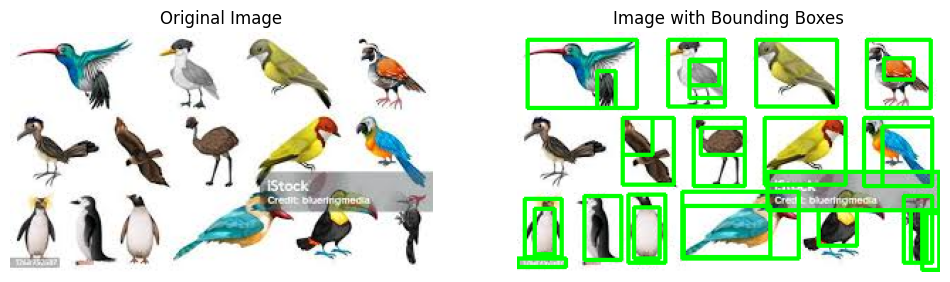

In [69]:
bounding_boxes = []
for mask in filtered_masks:
    # Extract the binary segmentation array from the mask dictionary
    segmentation = mask  # If `filtered_masks` already contains segmentation arrays
    if isinstance(mask, dict):
        segmentation = mask.get("segmentation", None)
    
    if segmentation is None:
        continue  # Skip if no segmentation data is available
    
    # Ensure mask is binary (0 and 1 only)
    binary_mask = (segmentation > 0).astype(np.uint8)
    
    # Check if mask contains any valid region
    coords = np.where(binary_mask == 1)
    if len(coords[0]) > 0 and len(coords[1]) > 0:  # Ensure the mask is not empty
        y_coords, x_coords = coords
        x_min, x_max = x_coords.min(), x_coords.max()
        y_min, y_max = y_coords.min(), y_coords.max()
        bounding_boxes.append((x_min, y_min, x_max, y_max))

# Draw bounding boxes on the original image
output_image = image_bgr.copy()
for (x_min, y_min, x_max, y_max) in bounding_boxes:
    cv2.rectangle(output_image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

# Visualize the results
images = [image_bgr, output_image]
titles = ["Original Image", "Image with Bounding Boxes"]

# Use Supervision's plot_images_grid function
sv.plot_images_grid(
    images=images,
    grid_size=(1, 2),
    titles=titles
)


In [78]:
import os

IMAGE_NAME = "images.jpeg"
IMAGE_PATH = os.path.join(HOME, "segmentation", IMAGE_NAME)

In [79]:
import cv2
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb)

In [17]:
print(sam_result[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


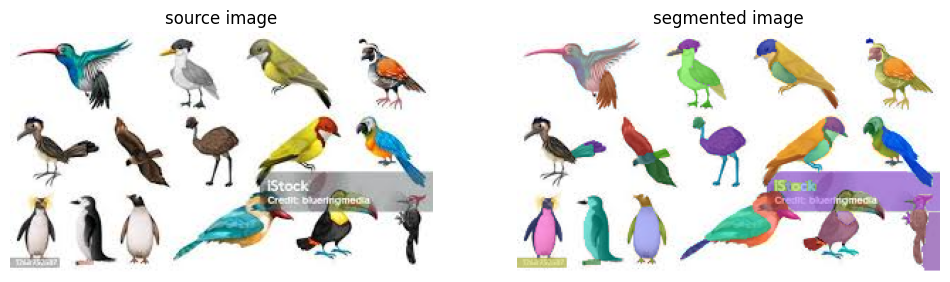

In [70]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

In [19]:
print(len(sam_result))

38


In [50]:
import math

# Number of images
num_images = len(sam_result)

# Calculate the number of rows and columns
rows = math.ceil(num_images / 10)  # Ensure enough rows to fit all images
cols = min(10, num_images)  # Maximum 10 columns, adjust if fewer images

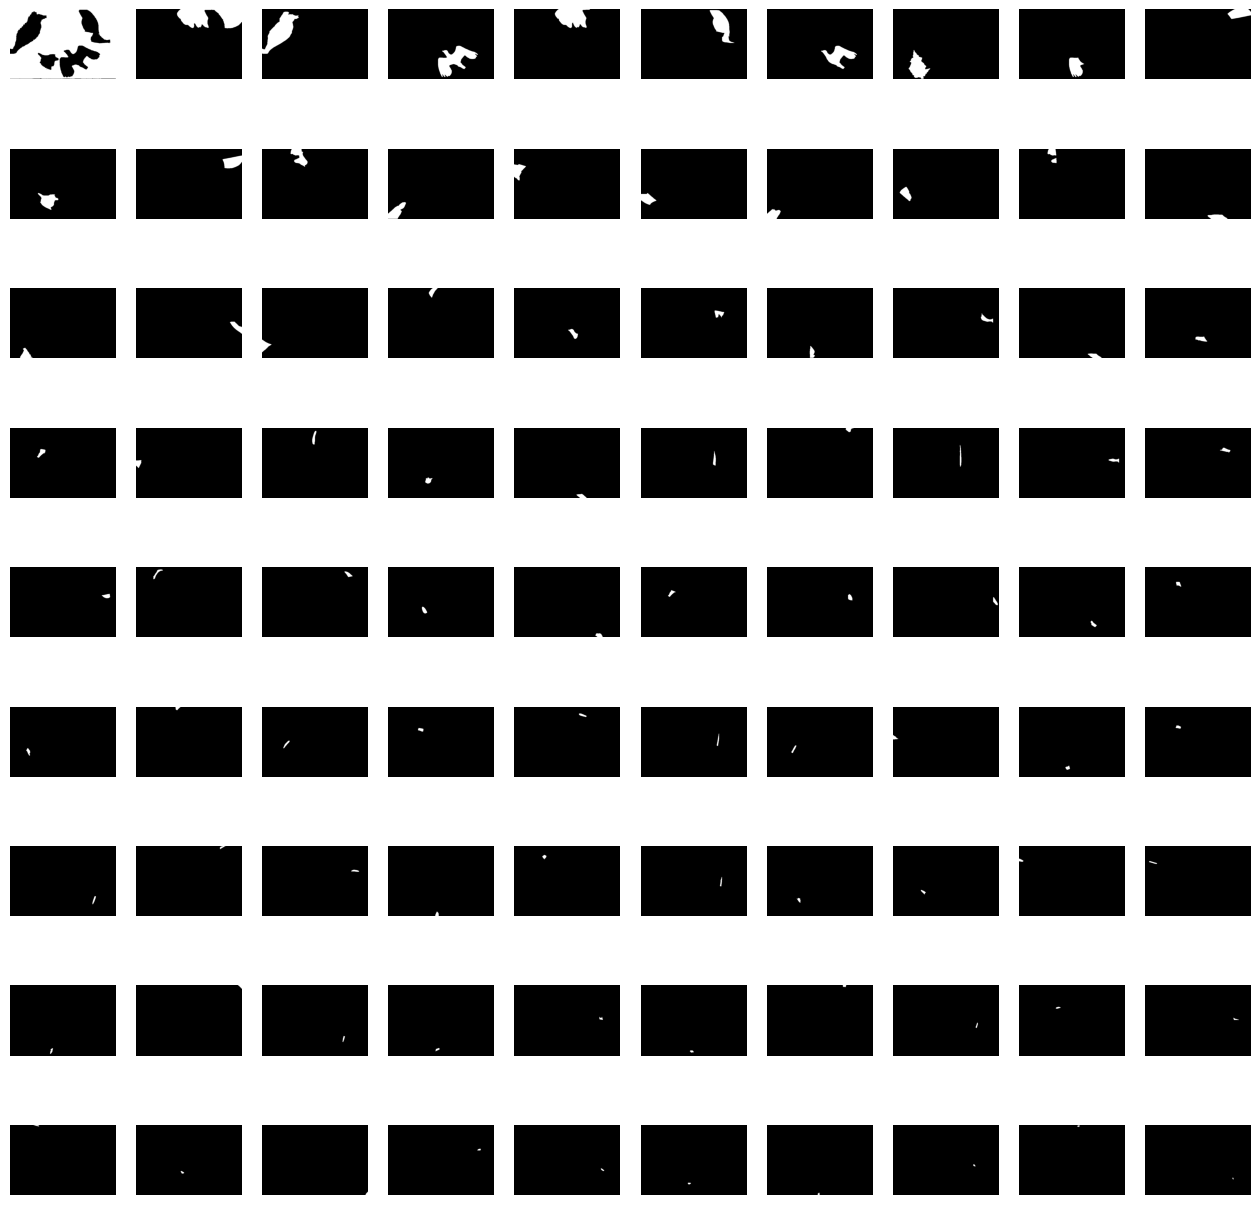

In [56]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks,
    grid_size=(rows, cols),
    size=(16, 16)
)

In [17]:
mask_predictor = SamPredictor(sam)

In [18]:
import numpy as np

box = np.array([68, 247, 623, 925])

In [19]:
import cv2
import numpy as np
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

In [43]:
import cv2
import numpy as np
import supervision as sv
from segment_anything import SamPredictor, sam_model_registry

# Assuming all your previous setup code (DEVICE, MODEL_TYPE, sam, etc.) is already run

def visualize_with_boxes(image_path, mask_generator):
    # Read and convert image
    image_bgr = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    
    # Generate SAM masks
    sam_result = mask_generator.generate(image_rgb)
    
    # Create annotators
    mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
    # Configure box annotator with index-based color lookup
    box_annotator = sv.BoxAnnotator(color=(0, 0, 255), color_lookup=sv.ColorLookup.INDEX)
    
    # Convert SAM results to Detections format
    detections = sv.Detections.from_sam(sam_result=sam_result)
    
    # Create a copy of the image for annotation
    annotated_image = image_bgr.copy()
    
    # Add masks
    annotated_image = mask_annotator.annotate(scene=annotated_image, detections=detections)
    
    # Add boxes
    annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
    
    # Create labels with area information
    labels = [f"Segment {i}, Area: {mask['area']:.0f}" 
             for i, mask in enumerate(sam_result)]
    
    # Visualize results
    sv.plot_images_grid(
        images=[image_bgr, annotated_image],
        grid_size=(1, 2),
        titles=['source image', 'segmented image with boxes']
    )
    
    return sam_result, detections

# Function to get detailed information about segments
def analyze_segments(sam_result):
    segments_info = []
    for i, segment in enumerate(sam_result):
        info = {
            'segment_id': i,
            'area': segment['area'],
            'bbox': segment['bbox'],  # [x, y, w, h]
            'predicted_iou': segment['predicted_iou'],
            'stability_score': segment['stability_score']
        }
        segments_info.append(info)
    
    # Sort by area for easy reference
    segments_info.sort(key=lambda x: x['area'], reverse=True)
    return segments_info

# Usage
sam_result, detections = visualize_with_boxes(IMAGE_PATH, mask_generator)
segments_info = analyze_segments(sam_result)

# Print information about segments
print("\nSegment Information (sorted by area):")
for info in segments_info:
    print(f"\nSegment {info['segment_id']}:")
    print(f"  Area: {info['area']:.0f}")
    print(f"  Bounding Box (x,y,w,h): {[round(x, 2) for x in info['bbox']]}")
    print(f"  Predicted IOU: {info['predicted_iou']:.3f}")
    print(f"  Stability Score: {info['stability_score']:.3f}")
    

AttributeError: 'tuple' object has no attribute 'as_bgr'

In [55]:
im = cv2.imread(str(seg_path), 0)

# Segmentation color value (in Blender this is likely your pass index)
seg_value = 1

if im is not None:
    np_seg = np.array(im)
    segmentation = np.where(np_seg == seg_value)

    # Bounding Box
    bbox = 0, 0, 0, 0
    if len(segmentation) != 0 and len(segmentation[1]) != 0 and len(segmentation[0]) != 0:
        x_min = int(np.min(segmentation[1]))
        x_max = int(np.max(segmentation[1]))
        y_min = int(np.min(segmentation[0]))
        y_max = int(np.max(segmentation[0]))

        bbox = x_min, x_max, y_min, y_max

        #########
        # Do what you need to do with the bbox, for example add it to your annotation file
        #########
else:
    # Handle error case where segmentation image cannot be read or is empty
    print("Error: Segmentation image could not be read or is empty.")

In [54]:
seg_path = '/Users/anshmadan/Coding/IML Final Project/segmentation/output/1.png'